
=== LLM 메모리 통합 대시보드 ===
질문 입력 (종료: q)

질문 1: 안녕하세요. 오늘 날씨 알려줘.
질문 2: 학생들에게 추천할 책 5권 알려줘.
질문 3: 지난번 대화에서 이야기한 것 기억하고 그 내용을 이어서 설명해줘.
질문 4: 아래 글을 요약해줘. 정해진 총액 이하에서 가능한 한 최대의 총 예산을 다음과 같은 방법으로 배정한다.  1. 모든 요청이 배정될 수 있는 경우에는 요청한 금액을 그대로 배정한다. 2. 모든 요청이 배정될 수 없는 경우에는 **특정한 정수 상한액**을 계산하여 그 이상인 예산 요청에는 모두 상한액을 배정한다. 상한액 이하의 예산 요청에 대해서는 요청한 금액을 그대로 배정한다.  예를 들어, **전체 국가예산이 485**이고 4개 지방의 예산요청이 각각 **120**, **110**, **140**, **150**이라고 하자. 이 경우, **상한액을 127**로 잡으면, 위의 요청들에 대해서 각각 **120**, **110**, **127**, **127**을 배정하고 그 합이 484로 가능한 최대가 된다.  여러 지방의 예산요청과 국가예산의 총액이 주어졌을 때, 위의 조건을 모두 만족하도록 예산을 배정하는 프로그램을 작성  ⇒ 전부 다 최대치로 줄 수 없다면, 큰 애들부터 특정 정수 상한액을 배정한다. (가능한 되는 애들은 최대치로 줌)  첫째 줄에는 지방의 수를 의미하는 정수 N이 주어진다. N은 3 이상 10,000 이하  다음 줄에는 각 지방의 예산요청을 표현하는 N개의 정수가 빈칸을 사이에 두고 주어진다. 값들은 모두 1 이상 100,000 이하  그 다음 줄에는 총 예산을 나타내는 정수 M. M은 N 이상 1,000,000,000 이하  첫째 줄에는 배정된 예산들 중 최댓값인 정수를 출력
질문 5: 코드 리뷰해줘: import matplotlib.pyplot as plt import matplotlib.font_manager as fm import numpy as np import math  # ------

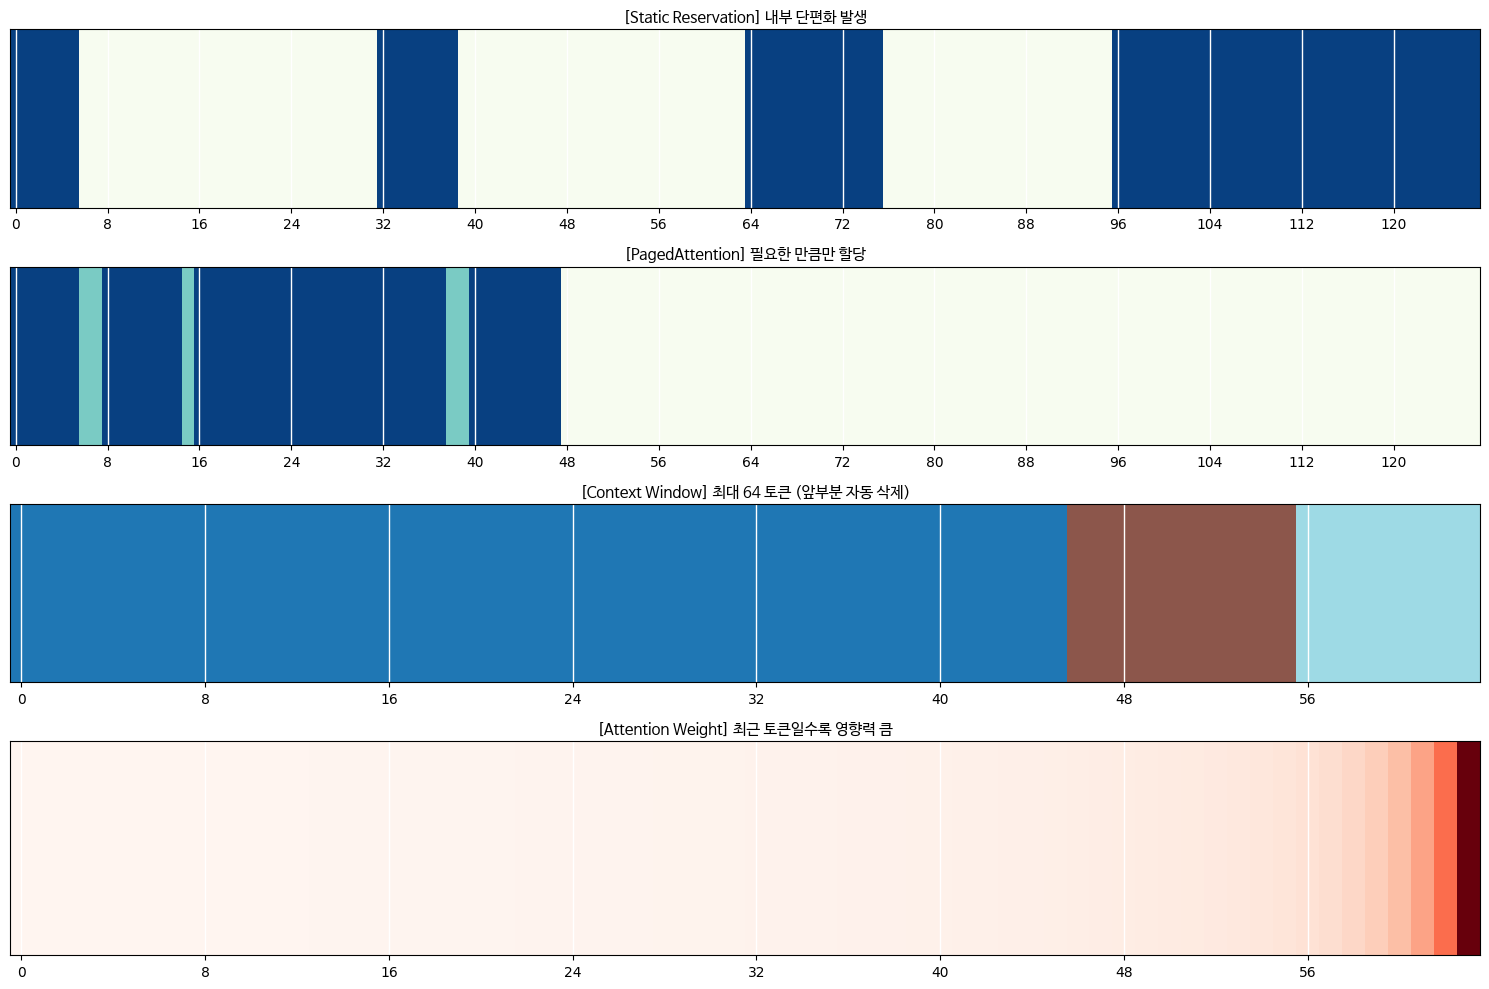


잘려나간 토큰 수: 677


In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import math

# -------------------------------
# 한글 폰트 설정
# -------------------------------
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = fm.FontProperties(fname=font_path, size=11)
plt.rc('font', family='NanumBarunGothic')

# -------------------------------
# 시스템 설정
# -------------------------------
TOTAL_VRAM_BLOCKS = 128
MAX_RESERVATION = 32
PAGE_SIZE = 4
MAX_CONTEXT = 64

def get_token_estimate(text):
    return math.ceil(len(text.split()) * 1.3)

# -------------------------------
# 통합 시뮬레이션
# -------------------------------
def run_llm_memory_dashboard():

    print("\n=== LLM 메모리 통합 대시보드 ===")
    print("질문 입력 (종료: q)\n")

    prompts = []
    while True:
        user_input = input(f"질문 {len(prompts)+1}: ")
        if user_input.lower() == 'q':
            break
        prompts.append(user_input)

    request_lengths = [get_token_estimate(p) for p in prompts]

    # -------------------------------
    # 1️⃣ Static vs Paged
    # -------------------------------
    static_vram = np.zeros(TOTAL_VRAM_BLOCKS)
    paged_vram = np.zeros(TOTAL_VRAM_BLOCKS)

    curr_static = 0
    curr_paged = 0

    for length in request_lengths:

        # Static
        if curr_static + MAX_RESERVATION <= TOTAL_VRAM_BLOCKS:
            static_vram[curr_static:curr_static+length] = 2
            static_vram[curr_static+length:curr_static+MAX_RESERVATION] = 1
            curr_static += MAX_RESERVATION

        # Paged
        req_pages = math.ceil(length / PAGE_SIZE)
        req_blocks = req_pages * PAGE_SIZE

        if curr_paged + req_blocks <= TOTAL_VRAM_BLOCKS:
            paged_vram[curr_paged:curr_paged+length] = 2
            paged_vram[curr_paged+length:curr_paged+req_blocks] = 1
            curr_paged += req_blocks

    # -------------------------------
    # 2️⃣ Context Window
    # -------------------------------
    conversation_tokens = []
    truncated_tokens = []

    for i, length in enumerate(request_lengths):
        conversation_tokens += [i+1] * length

        if len(conversation_tokens) > MAX_CONTEXT:
            overflow = len(conversation_tokens) - MAX_CONTEXT
            truncated_tokens += conversation_tokens[:overflow]
            conversation_tokens = conversation_tokens[overflow:]

    context_array = np.zeros(MAX_CONTEXT)
    context_array[:len(conversation_tokens)] = conversation_tokens

    # -------------------------------
    # 3️⃣ Attention 희석
    # -------------------------------
    if len(conversation_tokens) > 0:
        distances = np.arange(len(conversation_tokens))[::-1] + 1
        attention_weights = 1 / distances
        attention_weights = attention_weights / attention_weights.max()
    else:
        attention_weights = np.zeros(1)

    # -------------------------------
    # 시각화
    # -------------------------------
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(4, 1, height_ratios=[1, 1, 1, 1.2])

    # Static
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(static_vram.reshape(1, -1), aspect='auto', cmap='GnBu')
    ax1.set_title("[Static Reservation] 내부 단편화 발생", fontproperties=font_prop)
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(0, TOTAL_VRAM_BLOCKS, 8))
    ax1.grid(color='white', linewidth=1)

    # Paged
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.imshow(paged_vram.reshape(1, -1), aspect='auto', cmap='GnBu')
    ax2.set_title("[PagedAttention] 필요한 만큼만 할당", fontproperties=font_prop)
    ax2.set_yticks([])
    ax2.set_xticks(np.arange(0, TOTAL_VRAM_BLOCKS, 8))
    ax2.grid(color='white', linewidth=1)

    # Context Window
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.imshow(context_array.reshape(1, -1), aspect='auto', cmap='tab20')
    ax3.set_title(f"[Context Window] 최대 {MAX_CONTEXT} 토큰 (앞부분 자동 삭제)", fontproperties=font_prop)
    ax3.set_yticks([])
    ax3.set_xticks(np.arange(0, MAX_CONTEXT, 8))
    ax3.grid(color='white', linewidth=1)

    # Attention
    ax4 = fig.add_subplot(gs[3, 0])
    ax4.imshow(attention_weights.reshape(1, -1), aspect='auto', cmap='Reds')
    ax4.set_title("[Attention Weight] 최근 토큰일수록 영향력 큼", fontproperties=font_prop)
    ax4.set_yticks([])
    ax4.set_xticks(np.arange(0, len(attention_weights), 8))
    ax4.grid(color='white', linewidth=1)

    plt.tight_layout()
    plt.show()

    print(f"\n잘려나간 토큰 수: {len(truncated_tokens)}")

# 실행
run_llm_memory_dashboard()
